In [1]:
import os
#os.chdir(f"..")
from utilities import *
from plot_utilities import *
import matlab.engine 
import scipy.stats as stats
import matlab.engine 
eng = matlab.engine.connect_matlab()

In [2]:
#os.chdir(f"..")

In [8]:
os.getcwd()

'/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/testing-framework'

In [4]:
def compute_prior_pdf(r, eta, n_samples = 10000, tail_bound = 0.05, tail_percent = 0.01, scale = 1, scipy_int=True):

    '''
    Returns support and pdf for prior distribution
    r : shape parameter controlling rate of exponentional decay
    eta : controls roundedness of peak, and hence sparsity
    scale : scale parameter
    n_samples : number of points used to numerically approximate CDF
    tail_bound : Uses Chebyshev's Inequality to bound the region of the CDF that is outside the coverage of xs
    n_tail : Sets the number of points tha lie outside the coverage of xs to approximate tails if need be

    Usage:
    new_pdf = compute_prior_cdf(r = 0.1, eta = 0.001)
    new_pdf(0.5343) returns CDF
    Can also accept arrays
    '''
    
    beta = (eta + 1.5)/r 
    var_prior = scale * scipy.special.gamma((eta + 1.5 + 2)/r)/scipy.special.gamma(beta)
    cheby = np.sqrt(np.round(var_prior/(tail_bound)))
    x_max = min(99, cheby) # introduced additional bound in case chebyshev is unwieldy
    if cheby < 120:
        n_tail = 0
        print("No Tail")

    n_tail = int(n_samples* tail_percent)
        
    xs = np.linspace(-x_max, x_max, n_samples-2*n_tail)
    xs = np.append(-np.logspace(np.log10(cheby), 2, n_tail), xs)
    xs = np.append(xs, np.logspace(2, np.log10(cheby), n_tail))
    prior_pdf = np.full(xs.shape, np.nan)

    # Loop over xs
    for j, x in enumerate(xs):

        # Define integrands
        def gauss_density(theta):
            return (1./(np.sqrt(2*np.pi)*theta)) * np.exp(-0.5*(x/theta)**2)

        def gen_gamma_density(theta):
            return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)

        def integrand(theta):
            return gauss_density(theta) * gen_gamma_density(theta)

        # Integrate 
        if scipy_int:
            prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]
        else:
            prior_pdf[j] = eng.compute_prior(float(r), float(eta), float(x), nargout=1)
    return xs, prior_pdf

In [5]:
def compute_prior_cdf(r, eta, n_samples = 1000, tail_bound = 0.05, tail_percent = 0.01, scale = 1, scipy_int=True, support = False):

    '''
    Returns PPoly-type function that approximates the prior CDF of the signal x
    r : shape parameter controlling rate of exponentional decay
    eta : controls roundedness of peak, and hence sparsity
    scale : scale parameter
    n_samples : number of points used to numerically approximate CDF
    tail_bound : Uses Chebyshev's Inequality to bound the region of the CDF that is outside the coverage of xs
    n_tail : Sets the number of points tha lie outside the coverage of xs to approximate tails if need be

    Usage:
    new_cdf = compute_prior_cdf(r = 0.1, eta = 0.001)
    new_cdf(0.5343) returns CDF
    Can also accept arrays
    '''
    
    beta = (eta + 1.5)/r 
    var_prior = scale * scipy.special.gamma((eta + 1.5 + 2)/r)/scipy.special.gamma(beta)
    cheby = np.sqrt(np.round(var_prior/(tail_bound)))
    

    n_tail = int(n_samples*tail_percent)
    
    x_max = min(99, cheby) # introduced additional bound in case chebyshev is unwieldy
    if cheby < 120:
        n_tail = 0
        print("No Tail")
    

    xs = np.linspace(-x_max, x_max, n_samples-2*n_tail)
    xs = np.append(-np.logspace(np.log10(cheby), 2, n_tail), xs)
    xs = np.append(xs, np.logspace(2, np.log10(cheby), n_tail))
    prior_pdf = np.full(xs.shape, np.nan)

    for j, x in enumerate(xs):

        def gauss_density(theta):
            return (1./(np.sqrt(2*np.pi)*theta)) * np.exp(-0.5*(x/theta)**2)

        def gen_gamma_density(theta):
            return (r/scipy.special.gamma(beta)) * (1/scale) * (theta/scale)**(r*beta - 1) * np.exp(-(theta/scale)**r)

        def integrand(theta):
            return gauss_density(theta) * gen_gamma_density(theta)

        if scipy_int:
            prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]
        else:
            prior_pdf[j] = eng.compute_prior(float(r), float(eta), float(x), nargout=1)

    prior_cdf = np.zeros_like(prior_pdf)
    prior_cdf[0] = 0
    for i in range(1, len(xs)):
        prior_cdf[i] = (interpolate.CubicSpline(x = xs[:i+1], y = prior_pdf[:i+1])).integrate(xs[0], xs[i])+0

        # Alternative with Simpson's: prior_cdf[i] = integrate.simps(prior_pdf[:i+1], xs[:i+1])
    normalizer = prior_cdf[-1]
    first = prior_cdf[1]
    assert 1.05 > normalizer > 0.95
    assert 0.05 > first > -0.05
    prior_cdf = prior_cdf/normalizer   

    k = int(0.01*n_samples)
    zero_padding = np.zeros(k)
    ones_padding = np.ones(k)

    pad_max = max(10e5, np.round(cheby ** 2))


    prior_cdf = np.append(zero_padding, prior_cdf)
    xs_pad = np.append(np.linspace(-pad_max, xs[0] - 1e-5, k), xs)

    prior_cdf = np.append(prior_cdf, ones_padding)
    xs_pad = np.append(xs_pad, np.linspace(xs[-1] + 1e-5, pad_max, k))

    poly = interpolate.CubicSpline(x = xs_pad, y = prior_cdf)


    if support:
        return xs, poly
    else:
        return poly

In [22]:
data_dict = pd.read_pickle('../data/Panoptic Agriculture/Transformed Dataset/Panoptic_Data_Dict_Normalized.pickle')
obs_x_dict = dict()
for layer in np.arange(2, 9):
     obs_x_dict[layer] = create_obs_x(data_dict, layer)
pd.to_pickle(obs_x_dict, 'panoptic/obs_x_dict.pickle')

obs_x_dict = pd.read_pickle('panoptic/obs_x_dict.pickle') # Already sorted
obs_x_dict

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -43.34915759, -36.2290875 , ...,  36.11999915,
         38.35812055,  42.17747737]),
 6: array([-23.87540781, -23.66829959, -23.29668418, ...,  25.41955052,
         31.52717851,  44.79754701]),
 7: array([-19.12997336, -18.52962064, -17.2224645 , ...,  16.63923718,
         17.96650462,  20.30569957]),
 8: array([-18.71256003, -17.84609759, -16.94317757, ...,  15.43083627,
         16.78232461,  20.5891778 ])}

In [ ]:
compute_prior_cdf(r = -5, eta = 4)

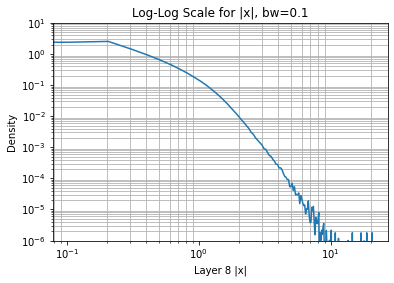

In [21]:
bw = 0.1
layer = 8
x = np.abs(obs_x_dict[layer])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE)")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-6, top=10)
plt.xlabel(f'Layer {layer} |x|')
plt.title(f'Log-Log Scale for |x|, bw={bw}')
plt.grid(True, 'minor')

# Layer 7 r = 4.629 $\eta$ = 0 n = 3256320

In [6]:
r = 4.629
eta = 0
n = 3256320
no_diagonal = layer_dict[7][layer_dict[7]["Orientation"] != "D"]
flat = np.concatenate(no_diagonal["Data"].values.flatten())
sampled_prior = sample_prior(r, eta, size = n)
xs, prior_den = compute_prior_pdf(r =r, eta= eta, n_samples = 10000,  tail_bound = 0.01, tail_percent = 0.01, scipy_int = False)

No Tail


In [7]:
pcdf = compute_prior_cdf(r =r, eta= eta, n_samples = 10000,  tail_bound = 0.01, tail_percent = 0.01, scipy_int = False)

No Tail


Text(0.5, 0.98, 'Layer 7 r = 4.629 $\\eta$ = 0 stat = 0.24877 n = 3256320')

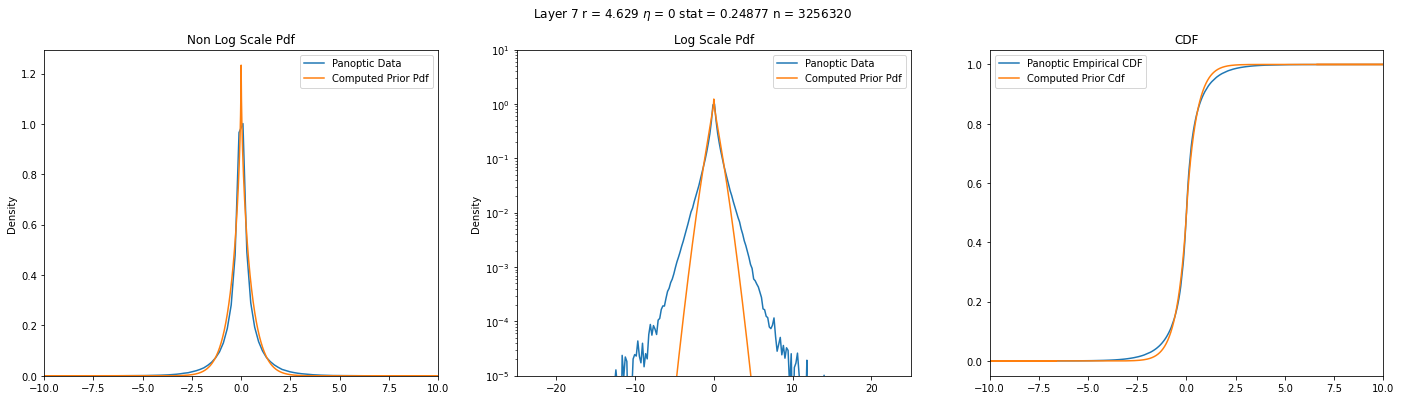

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
axes[0].set_xlim(left = -10, right = 10)
axes[1].set_xlim(left = -25, right = 25)
axes[1].set_ylim(bottom = 10**-5, top= 10)
axes[2].set_xlim(left = -10, right = 10)
sns.kdeplot(ax = axes[0], x = flat, bw_method = 0.02, label = "Panoptic Data")
#sns.kdeplot(ax = axes[1], x = sampled_prior, bw_method = 0.2, label = "Sampled Prior")
axes[0].plot(xs, prior_den, label = "Computed Prior Pdf")
sns.kdeplot(ax = axes[1], x = flat, bw_method = 0.02, log_scale=[False, True], label = "Panoptic Data")
#sns.kdeplot(ax = axes[1], x = sampled_prior, bw_method = 0.2, log_scale=[False, True], label = "Sampled Prior")
axes[1].plot(xs, prior_den, label = "Computed Prior Pdf")
axes[2].plot(np.sort(flat), np.arange(1, n+1)/n, label='Panoptic Empirical CDF')
#axes[2].plot(np.sort(sampled_prior), np.arange(1, n+1)/n, label='Sampled Prior Empirical CDF')
axes[2].plot(xs, pcdf(xs), label = "Computed Prior Cdf")
axes[0].set_title("Non Log Scale Pdf")
axes[1].set_title("Log Scale Pdf")
axes[2].set_title("CDF")
axes[0].legend()
axes[1].legend()
axes[2].legend()
fig.suptitle("Layer 7 r = 4.629 $\eta$ = 0 stat = 0.24877 n = 3256320")

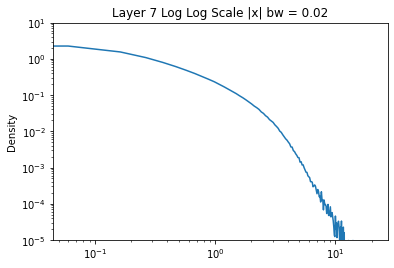

In [10]:
bw = 0.02
plt.ylim(bottom = 10**-5, top= 10)
abs_flat = abs(flat)
sns.kdeplot(x = abs_flat, bw_method = bw, log_scale=[False, True])
plt.title(f"Layer 7 Log Log Scale |x| bw = {bw}")
plt.xscale('log')
plt.show()

# Layer 8 r = 5.701 $\eta$ = 0 n = 13025280

In [8]:
r = 5.701
eta = 0
n = 13025280
no_diagonal = layer_dict[8][layer_dict[8]["Orientation"] != "D"]
flat = np.concatenate(no_diagonal["Data"].values.flatten())
sampled_prior = sample_prior(r, eta, size = n)
xs, prior_den = compute_prior_pdf(r =r, eta= eta, n_samples = 10000,  tail_bound = 0.01, tail_percent = 0.01, scipy_int = False)

No Tail


In [9]:
pcdf = compute_prior_cdf(r =r, eta= eta, n_samples = 10000,  tail_bound = 0.01, tail_percent = 0.01, scipy_int = False)

No Tail


Text(0.5, 0.98, 'Layer 8 r = 5.701 $\\eta$ = 0 stat = 0.24877 n = 13025280')

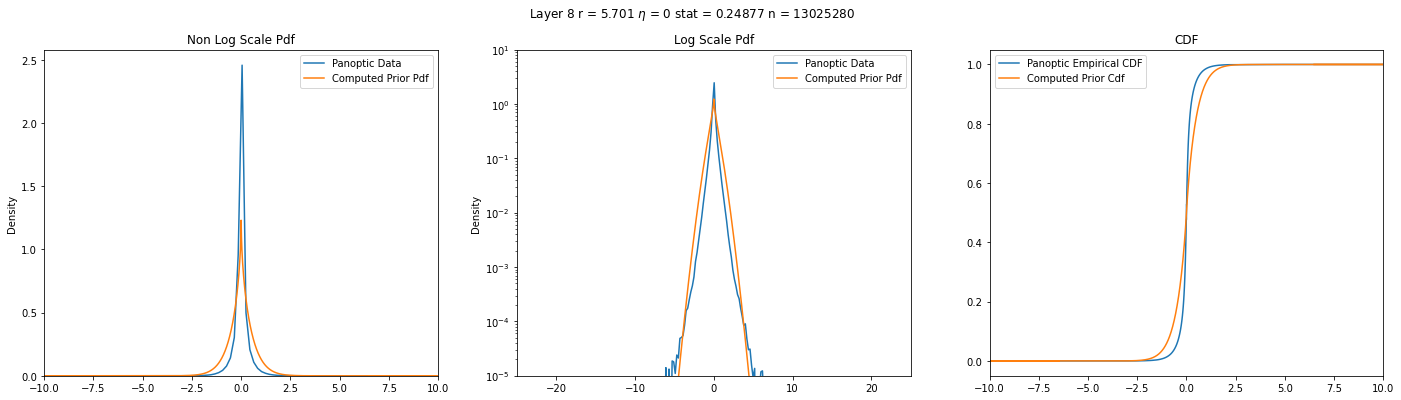

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
axes[0].set_xlim(left = -10, right = 10)
axes[1].set_xlim(left = -25, right = 25)
axes[1].set_ylim(bottom = 10**-5, top= 10)
axes[2].set_xlim(left = -10, right = 10)
sns.kdeplot(ax = axes[0], x = flat, bw_method = 0.02, label = "Panoptic Data")
#sns.kdeplot(ax = axes[1], x = sampled_prior, bw_method = 0.2, label = "Sampled Prior")
axes[0].plot(xs, prior_den, label = "Computed Prior Pdf")
sns.kdeplot(ax = axes[1], x = flat, bw_method = 0.02, log_scale=[False, True], label = "Panoptic Data")
#sns.kdeplot(ax = axes[1], x = sampled_prior, bw_method = 0.2, log_scale=[False, True], label = "Sampled Prior")
axes[1].plot(xs, prior_den, label = "Computed Prior Pdf")
axes[2].plot(np.sort(flat), np.arange(1, n+1)/n, label='Panoptic Empirical CDF')
#axes[2].plot(np.sort(sampled_prior), np.arange(1, n+1)/n, label='Sampled Prior Empirical CDF')
axes[2].plot(xs, pcdf(xs), label = "Computed Prior Cdf")
axes[0].set_title("Non Log Scale Pdf")
axes[1].set_title("Log Scale Pdf")
axes[2].set_title("CDF")
axes[0].legend()
axes[1].legend()
axes[2].legend()
fig.suptitle("Layer 8 r = 5.701 $\eta$ = 0 stat = 0.24877 n = 13025280")

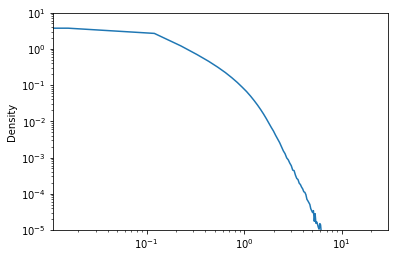

In [46]:
bw = 0.02
plt.ylim(bottom = 10**-5, top= 10)
abs_flat = abs(flat)
sns.kdeplot(x = abs_flat, bw_method = bw, log_scale=[False, True])
plt.title(f"Layer 7 Log Log Scale |x| bw = {bw}")
plt.xscale('log')
plt.show()

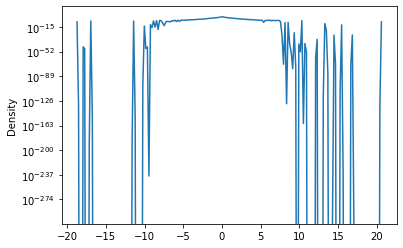

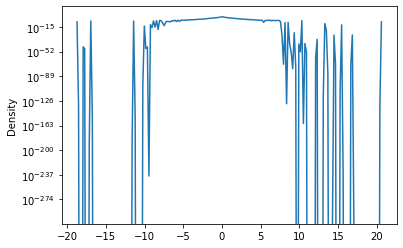

In [43]:
sns.kdeplot( x = flat, bw_method = 0.02, log_scale=[False, True], label = "Panoptic Data")
plt.show()
sns.kdeplot(x = flat, bw_method = 0.02, log_scale=[False, False], label = "Panoptic Data")
plt.yscale('log')
plt.show()

<AxesSubplot:ylabel='Density'>

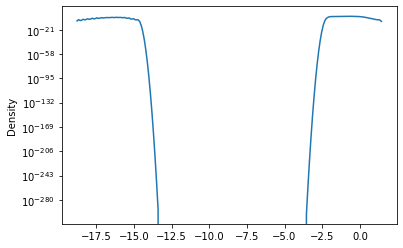

In [36]:
#plt.ylim(bottom = 10**-5, top= 10)
#plt.xlim(left = 10e-14, right = 10e-13)
sns.kdeplot(x = , bw_method = 0.02, log_scale=[False, True], label = "Panoptic Data")

In [31]:
right_log = np.log10(right)
right_log[]

In [35]:
right_log < - 5 and right_log >- 5 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
np.min(right)

2.168404344971009e-19

In [14]:
np.max(right)

20.58917780177214

In [ ]:
eng.quit()